# CSCM45 - Big Data and Machine Learning | Coursework: Object Recognition
### Sabir Uddin

<hr>

## Imports

### Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.feature

from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score #plot_confusion_matrix deprecated


# Tensorflow configuration
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Datasets

In [2]:
datasetPath = "./files/datasets/"
classPath = "./files/classes/"

# Training images - single image = (32x32x3)
trnImage = np.load(datasetPath + "trnImage.npy")  # (height, width, colour ch, samples)
trnLabel_coarse = np.load(datasetPath + "trnLabel_coarse.npy")
trnLabel_fine = np.load(datasetPath + "trnLabel_fine.npy")

# Testing images
tstImage = np.load(datasetPath + "tstImage.npy")  # (height, width, colour ch, samples)
tstLabel_coarse = np.load(datasetPath + "tstLabel_coarse.npy")
tstLabel_fine = np.load(datasetPath + "tstLabel_fine.npy")

# Labels
coarse_labels = np.genfromtxt(classPath + "coarse_labels.csv", delimiter=',', dtype=str)
fine_labels = np.genfromtxt(classPath + "fine_labels.csv", delimiter=',', dtype=str)

In [3]:
print(np.shape(trnImage), "\n",
    np.shape(trnLabel_coarse), "\n",
    np.shape(trnLabel_fine), "\n",
    np.shape(tstImage), "\n",
    np.shape(tstLabel_coarse), "\n",
    np.shape(tstLabel_fine)
    )

print("coarse_labels:\n", coarse_labels)
print("fine_labels:\n", fine_labels)

(32, 32, 3, 50000) 
 (50000,) 
 (50000,) 
 (32, 32, 3, 10000) 
 (10000,) 
 (10000,)
coarse_labels:
 ['aquatic mammals' 'fish' 'flowers' 'food containers'
 'fruit and vegetables' 'household electrical devices'
 'household furniture' 'insects' 'large carnivores'
 'large man-made outdoor things' 'large natural outdoor scenes'
 'large omnivores and herbivores' 'medium-sized mammals'
 'non-insect invertebrates' 'people' 'reptiles' 'small mammals' 'trees'
 'vehicles 1' 'vehicles 2']
fine_labels:
 ['apples' 'aquarium fish' 'baby' 'bear' 'beaver' 'bed' 'bee' 'beetle'
 'bicycle' 'bottles' 'bowls' 'boy' 'bridge' 'bus' 'butterfly' 'camel'
 'cans' 'castle' 'caterpillar' 'cattle' 'chair' 'chimpanzee' 'clock'
 'cloud' 'cockroach' 'couch' 'crab' 'crocodile' 'cups' 'dinosaur'
 'dolphin' 'elephant' 'flatfish' 'forest' 'fox' 'girl' 'hamster' 'house'
 'kangaroo' 'keyboard' 'lamp' 'lawn-mower' 'leopard' 'lion' 'lizard'
 'lobster' 'man' 'maple' 'motorcycle' 'mountain' 'mouse' 'mushrooms' 'oak'
 'oranges' '

In [4]:
# Change matrix from (W, H, C, S) to commonly used (S, W, H, C) - for use with CNN
trnImage = np.transpose(trnImage, (3, 0, 1, 2))
tstImage = np.transpose(tstImage, (3, 0, 1, 2))

print(np.shape(trnImage), "\n",
    np.shape(trnLabel_coarse), "\n",
    np.shape(trnLabel_fine), "\n",
    np.shape(tstImage), "\n",
    np.shape(tstLabel_coarse), "\n",
    np.shape(tstLabel_fine)
    )

(50000, 32, 32, 3) 
 (50000,) 
 (50000,) 
 (10000, 32, 32, 3) 
 (10000,) 
 (10000,)


In [5]:
# Get any category from the image dataset
def getImageCatergory(image_set, label_coarse, label_fine, category_number, num_categories=100):
    category_number = category_number - 1
    category_size = image_set.shape[-1] // num_categories
    
    images = []
    labels_coarse = []
    labels_fine = []
    
    for i in range(category_size):
        startPoint = i * category_size
        endPoint = (i+1) * category_size
        images.append(image_set[:,:,:,startPoint:endPoint].copy())
        labels_coarse.append(label_coarse[startPoint:endPoint].copy())
        labels_fine.append(label_fine[startPoint:endPoint].copy())
    
    return images[0], labels_coarse[0], labels_fine[0]

In [6]:
# Get number of images for an image dataset
def getNumImage(image):
    return np.shape(image)[0]

<hr>

## The Hand-crafted Feature Extractor

In [7]:
def extractFeaturesAndImagesSingle(image):
    hog_feature, hog_image = skimage.feature.hog(image, pixels_per_cell=[2,2], cells_per_block=[3,3], visualize=True, channel_axis=2)
    #print(f'The extracted feature vector is of length {hog_feature.shape[0]} per sample')
    return hog_feature, hog_image

# Extract features from a single image
def extractFeaturesSingle(image):
    hog_feature = skimage.feature.hog(image, pixels_per_cell=(8,8), cells_per_block=(3,3), orientations=9, visualize=False, channel_axis=2)
    #print(f'The extracted feature vector is of length {hog_feature.shape[0]} per sample')
    return hog_feature

In [8]:
feature_size = 2*2 * 3*3 * 9

# Adapting the feature extractor to get features for each category
def extractFeaturesSingleCategory(image_set, category, num_categories=100):
    category = category-1
    
    num_img = getNumImage(image_set/num_categories)
    hog_features = np.zeros((num_img, feature_size)) #15876
    
    cat_size = num_img // num_categories
    start_index = cat_size * category
    end_index = (cat_size * category) + cat_size
    print("Extracting HOG features from %d images between index %d and %d..." % (cat_size, start_index, end_index))
    
    for i in range(start_index, end_index):
        single_feature = extractFeaturesSingle(image_set[i,:,:,:])
        hog_features[i] = single_feature
    return hog_features


# Adapting the feature extractor to get features all categories
def extractFeaturesAllCategory(image_set):
    num_img = getNumImage(image_set)
    hog_features = np.zeros((num_img, feature_size))
    print("Extracting HOG features from %d images..." % (num_img))
    
    for i in range(num_img):
        single_feature = extractFeaturesSingle(image_set[i,:,:,:])
        hog_features[i] = single_feature
        
        if i%5000 == 0 and i != 0:
            print("Extracted %d images so far" % (i))
    return hog_features

<hr>

## Obtaining the Histogram of Oriented Gradients Features

## Coarse Labels (20 categories)

Extracting HOG features from 10000 images...


Extracted 5000 images so far
Extracting HOG features from 50000 images...
Extracted 5000 images so far
Extracted 10000 images so far
Extracted 15000 images so far
Extracted 20000 images so far
Extracted 25000 images so far
Extracted 30000 images so far
Extracted 35000 images so far
Extracted 40000 images so far
Extracted 45000 images so far


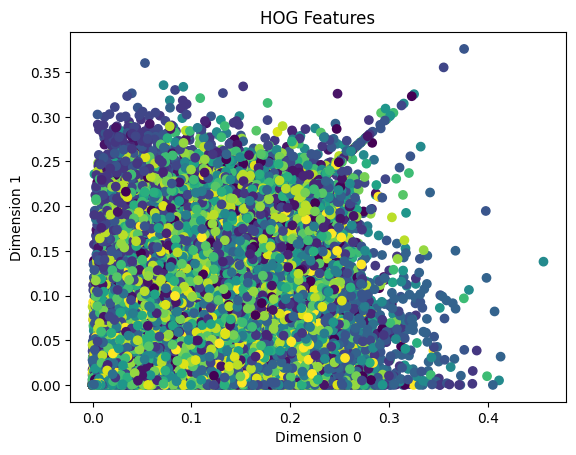

In [9]:
test_features = extractFeaturesAllCategory(tstImage)
train_features = extractFeaturesAllCategory(trnImage)

plt.figure()
plt.title("HOG Features")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.scatter(train_features[:,0], train_features[:,1], c=trnLabel_coarse) 
plt.show()

In [10]:
print(train_features.shape, test_features.shape)

(50000, 324) (10000, 324)


## Fine Labels (100 categories)

Extracting HOG features from 10000 images...
Extracted 5000 images so far
Extracting HOG features from 50000 images...
Extracted 5000 images so far
Extracted 10000 images so far
Extracted 15000 images so far
Extracted 20000 images so far
Extracted 25000 images so far
Extracted 30000 images so far
Extracted 35000 images so far
Extracted 40000 images so far
Extracted 45000 images so far


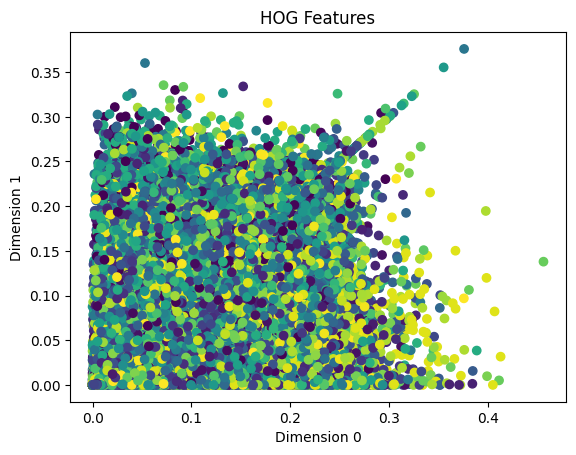

(10000, 324) (10000, 324)


In [11]:
test_features_fine = extractFeaturesAllCategory(tstImage)
train_features_fine = extractFeaturesAllCategory(trnImage)

plt.figure()
plt.title("HOG Features")
plt.xlabel("Dimension 0")
plt.ylabel("Dimension 1")
plt.scatter(train_features_fine[:,0], train_features_fine[:,1], c=trnLabel_fine) 
plt.show()

print(test_features_fine.shape, test_features_fine.shape)

## Standardising the data

In [12]:
# Standardise and transform features using StandardScaler() for both datasets

# Coarse labels
ss_coarse = StandardScaler()
ss_coarse.fit(train_features)
ss_train_coarse_std = ss_coarse.transform(train_features)
ss_test_coarse_std = ss_coarse.transform(test_features)


# Fine labels
ss_fine = StandardScaler()
ss_fine.fit(train_features_fine)
ss_train_fine_std = ss_fine.transform(train_features_fine)
ss_test_fine_std = ss_fine.transform(test_features_fine)

<hr>

## Functions for generating accuracy reports

In [13]:
# Confusion Matrix
def calculate_confusion_matrix(name, predicted_data, test_label, label_names):
    cm = confusion_matrix(test_label, predicted_data, normalize='true')
    #cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
    cm_display.plot(values_format='d', xticks_rotation='vertical', include_values=False)
    plt.title("Percentage Accuracy of " + name + ":")
    plt.show()


# Classification Report
def calculate_classification_report(name, predicted_data, test_label, label_names):
    cr = classification_report(test_label, predicted_data, target_names=label_names)
    print("Classification Report of " + name + ":")
    print(cr)

In [14]:
def plot_truth_vs_predicted(truth_data, truth_label, predicted_data, predicted_label):
    # Plotting test data
    fig = plt.figure(figsize=[10,5])
    fig.text(0.5, 0.025, "Feature Dimension 0", ha="center")

    plt.subplot(121)
    plt.scatter(predicted_data[:,0], predicted_data[:,1], c=predicted_label)
    plt.title("Ground Truth")
    plt.ylabel("Feature Dimension 1")

    plt.subplot(122)
    plt.scatter(truth_data[:,0], truth_data[:,1], c=truth_label)
    plt.title("Predicted Labels")
    plt.ylabel("Feature Dimension 1")

    plt.show()

In [15]:
def plot_acc_loss_curves(hist):
    # Plotting accuracy of test data vs prediction
    fig = plt.figure(figsize=[10,5])

    plt.subplot(121)
    plt.plot(hist.history['sparse_categorical_accuracy'])
    plt.plot(hist.history['val_sparse_categorical_accuracy'])
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title("Accuracy Curves")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")

    plt.subplot(122)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.legend(['Training Accuracy', 'Validation Accuracy'])
    plt.title("Loss Curves")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")

    plt.show()

<hr>

## Algorithm 1 - K-Means

In [16]:
def k_means_scatter(num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, n_init=10).fit(train_features)
    km_predict = kmeans.predict(test_features)

    plt.figure()
    plt.title("HOG Features (K-Means)")
    plt.xlabel("Dimension 0")
    plt.ylabel("Dimension 1")
    plt.scatter(test_features[:,0], test_features[:,1], c=km_predict)
    plt.show()

### Coarse Labels

#### n_clusters = 20

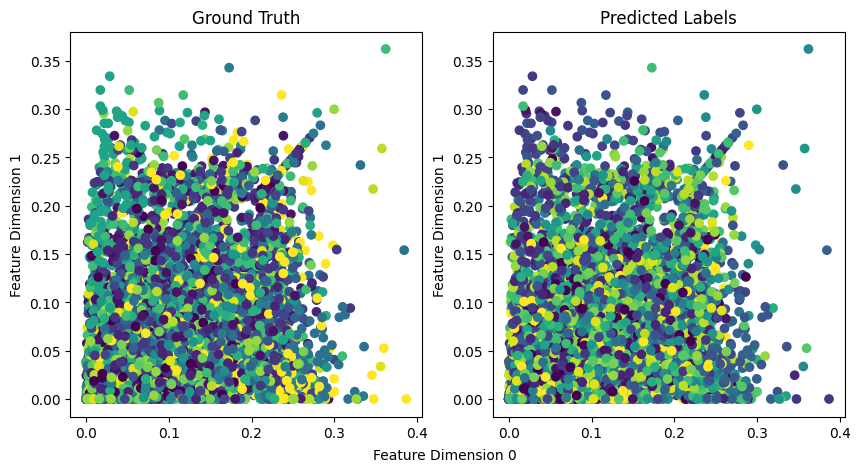

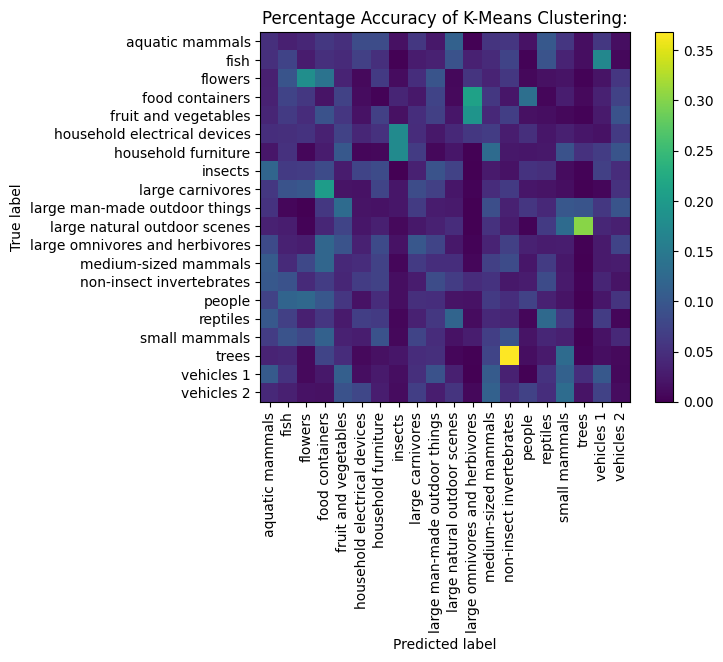

Classification Report of K-Means Clustering:
                                precision    recall  f1-score   support

               aquatic mammals       0.04      0.05      0.04       500
                          fish       0.06      0.07      0.07       500
                       flowers       0.18      0.18      0.18       500
               food containers       0.01      0.02      0.02       500
          fruit and vegetables       0.05      0.06      0.05       500
  household electrical devices       0.05      0.04      0.05       500
           household furniture       0.01      0.01      0.01       500
                       insects       0.00      0.00      0.00       500
              large carnivores       0.08      0.09      0.08       500
 large man-made outdoor things       0.03      0.03      0.03       500
  large natural outdoor scenes       0.05      0.05      0.05       500
large omnivores and herbivores       0.01      0.00      0.00       500
          medium-s

In [17]:
kmeans_n20 = KMeans(n_clusters=20, n_init=10).fit(train_features)
km_predict_n20 = kmeans_n20.predict(test_features)

plot_truth_vs_predicted(test_features, tstLabel_coarse, test_features, km_predict_n20)
calculate_confusion_matrix("K-Means Clustering", km_predict_n20, tstLabel_coarse, coarse_labels)
calculate_classification_report("K-Means Clustering", km_predict_n20, tstLabel_coarse, coarse_labels)

#### n_clusters = 10

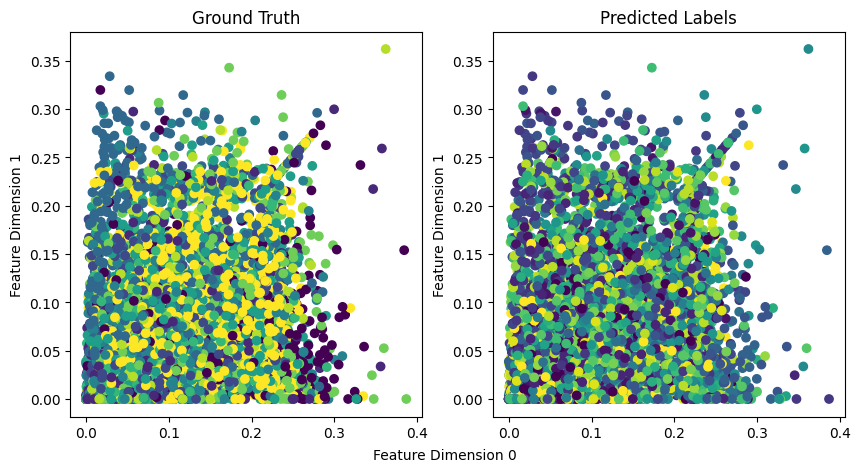

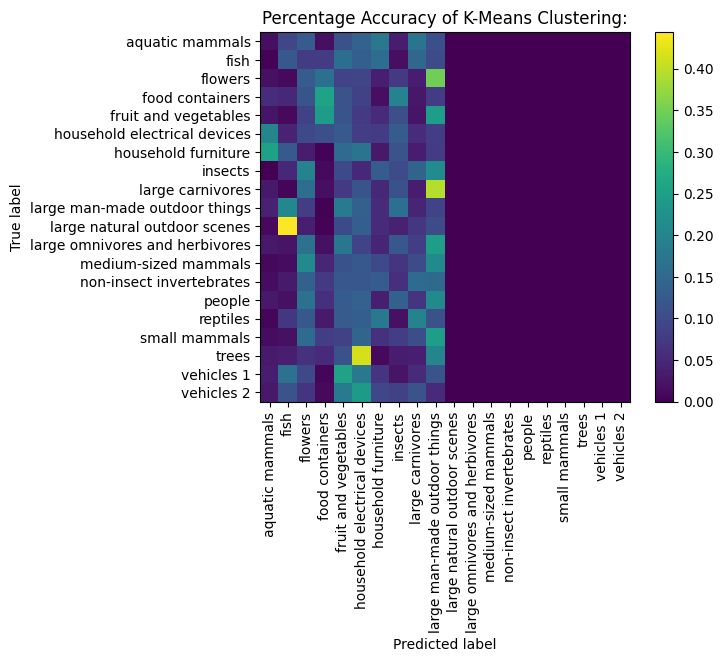

Classification Report of K-Means Clustering:
                                precision    recall  f1-score   support

               aquatic mammals       0.02      0.02      0.02       500
                          fish       0.07      0.12      0.09       500
                       flowers       0.06      0.13      0.08       500
               food containers       0.20      0.26      0.22       500
          fruit and vegetables       0.04      0.12      0.06       500
  household electrical devices       0.03      0.08      0.04       500
           household furniture       0.02      0.03      0.02       500
                       insects       0.06      0.10      0.08       500
              large carnivores       0.02      0.04      0.03       500
 large man-made outdoor things       0.03      0.09      0.04       500
  large natural outdoor scenes       0.00      0.00      0.00       500
large omnivores and herbivores       0.00      0.00      0.00       500
          medium-s

c:\Users\sabir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sabir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\sabir\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [18]:
kmeans_n10 = KMeans(n_clusters=10, n_init=10).fit(train_features)
km_predict_n10 = kmeans_n10.predict(test_features)

plot_truth_vs_predicted(test_features, tstLabel_coarse, test_features, km_predict_n10)
calculate_confusion_matrix("K-Means Clustering", km_predict_n10, tstLabel_coarse, coarse_labels)
calculate_classification_report("K-Means Clustering", km_predict_n10, tstLabel_coarse, coarse_labels)

### Fine Labels

#### n_clusters=100

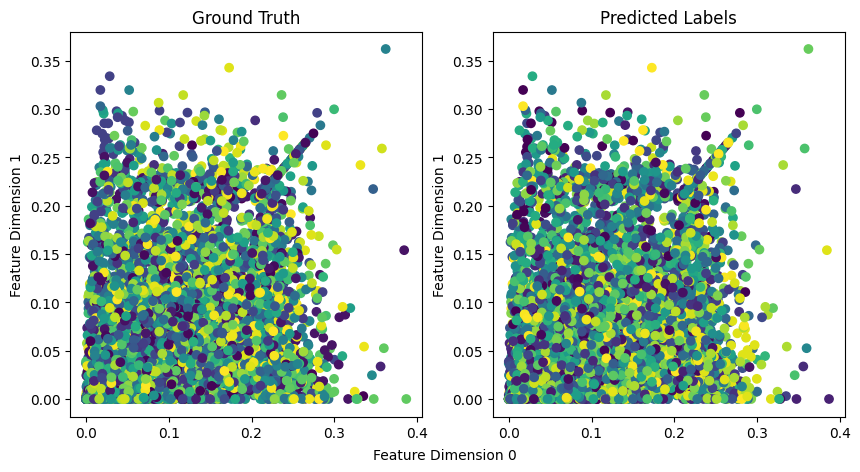

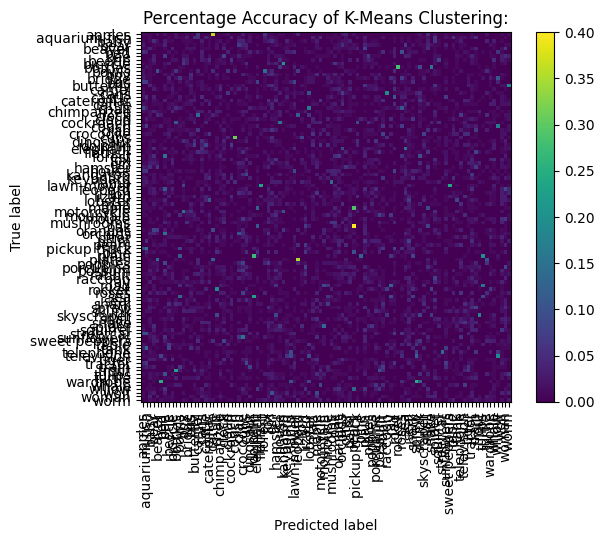

Classification Report of K-Means Clustering:
               precision    recall  f1-score   support

       apples       0.01      0.01      0.01       100
aquarium fish       0.00      0.00      0.00       100
         baby       0.01      0.01      0.01       100
         bear       0.01      0.01      0.01       100
       beaver       0.00      0.00      0.00       100
          bed       0.00      0.00      0.00       100
          bee       0.04      0.07      0.05       100
       beetle       0.00      0.00      0.00       100
      bicycle       0.00      0.00      0.00       100
      bottles       0.00      0.00      0.00       100
        bowls       0.01      0.01      0.01       100
          boy       0.00      0.00      0.00       100
       bridge       0.01      0.01      0.01       100
          bus       0.01      0.01      0.01       100
    butterfly       0.00      0.00      0.00       100
        camel       0.00      0.00      0.00       100
         cans      

In [19]:
kmeans_n100_fine = KMeans(n_clusters=100, n_init=10).fit(train_features_fine)
km_predict_n100_fine = kmeans_n100_fine.predict(test_features_fine)

plot_truth_vs_predicted(test_features_fine, tstLabel_fine, test_features_fine, km_predict_n100_fine)
calculate_confusion_matrix("K-Means Clustering", km_predict_n100_fine, tstLabel_fine, fine_labels)
calculate_classification_report("K-Means Clustering", km_predict_n100_fine, tstLabel_fine, fine_labels)

<hr>

## Algorithm 2 - Linear Discriminative Analysis (Coarse)

In [20]:
# Function

def lda_and_report(n_components, trn_features, trn_labels, tst_features, tst_labels, labels):
    lda = LDA(n_components=n_components)
    lda.fit(trn_features, trn_labels)
    lda_trn = lda.transform(trn_features)
    lda_tst = lda.transform(tst_features)
    tst_lda_predict = lda.predict(tst_features)
    calculate_confusion_matrix("Linear Discriminative Analysis", tst_lda_predict, tst_labels, labels)
    calculate_classification_report("Linear Discriminative Analysis", tst_lda_predict, tst_labels, labels)

### Coarse Labels

#### n_components=2

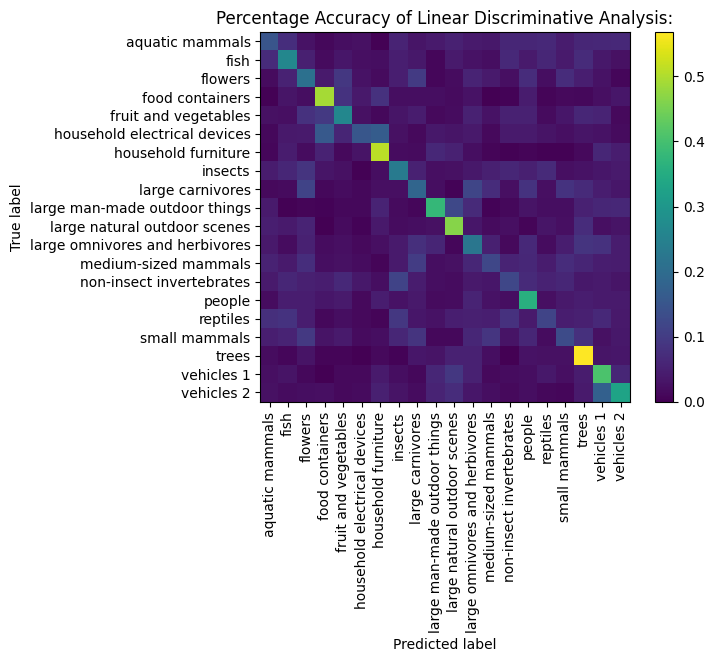

Classification Report of Linear Discriminative Analysis:
                                precision    recall  f1-score   support

               aquatic mammals       0.19      0.15      0.17       500
                          fish       0.26      0.26      0.26       500
                       flowers       0.18      0.21      0.20       500
               food containers       0.44      0.49      0.47       500
          fruit and vegetables       0.29      0.26      0.28       500
  household electrical devices       0.30      0.15      0.20       500
           household furniture       0.43      0.51      0.47       500
                       insects       0.24      0.23      0.24       500
              large carnivores       0.19      0.19      0.19       500
 large man-made outdoor things       0.40      0.38      0.39       500
  large natural outdoor scenes       0.39      0.46      0.42       500
large omnivores and herbivores       0.19      0.22      0.21       500
      

In [21]:
lda_and_report(2, train_features, trnLabel_coarse, test_features, tstLabel_coarse, coarse_labels)

#### n_components=9

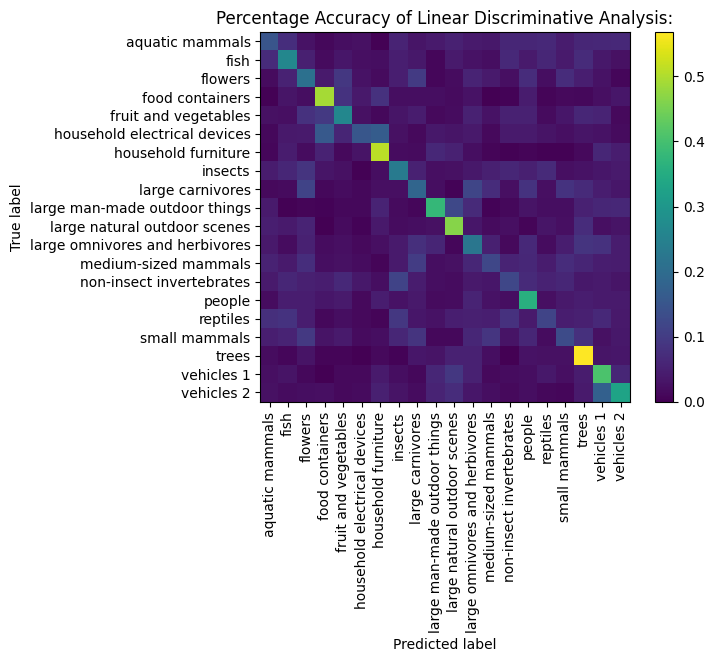

Classification Report of Linear Discriminative Analysis:
                                precision    recall  f1-score   support

               aquatic mammals       0.19      0.15      0.17       500
                          fish       0.26      0.26      0.26       500
                       flowers       0.18      0.21      0.20       500
               food containers       0.44      0.49      0.47       500
          fruit and vegetables       0.29      0.26      0.28       500
  household electrical devices       0.30      0.15      0.20       500
           household furniture       0.43      0.51      0.47       500
                       insects       0.24      0.23      0.24       500
              large carnivores       0.19      0.19      0.19       500
 large man-made outdoor things       0.40      0.38      0.39       500
  large natural outdoor scenes       0.39      0.46      0.42       500
large omnivores and herbivores       0.19      0.22      0.21       500
      

In [22]:
lda_and_report(9, train_features, trnLabel_coarse, test_features, tstLabel_coarse, coarse_labels)

#### n_components=19

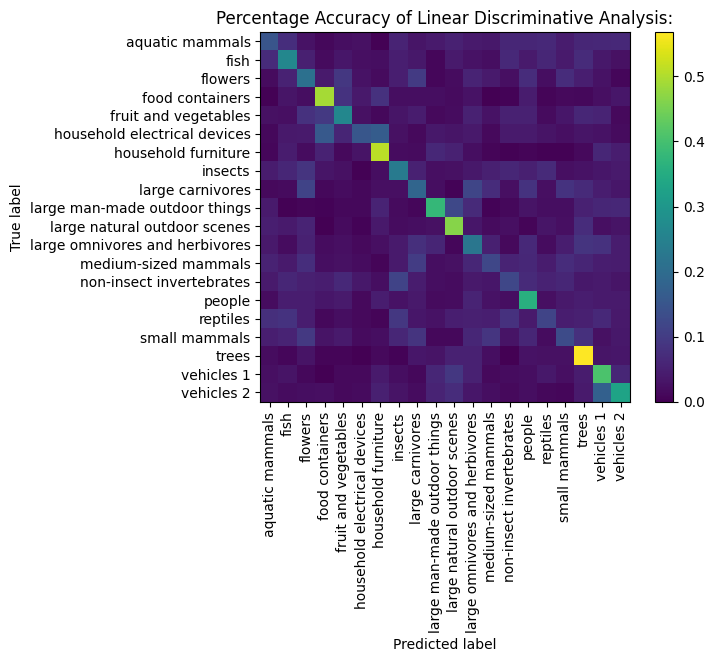

Classification Report of Linear Discriminative Analysis:
                                precision    recall  f1-score   support

               aquatic mammals       0.19      0.15      0.17       500
                          fish       0.26      0.26      0.26       500
                       flowers       0.18      0.21      0.20       500
               food containers       0.44      0.49      0.47       500
          fruit and vegetables       0.29      0.26      0.28       500
  household electrical devices       0.30      0.15      0.20       500
           household furniture       0.43      0.51      0.47       500
                       insects       0.24      0.23      0.24       500
              large carnivores       0.19      0.19      0.19       500
 large man-made outdoor things       0.40      0.38      0.39       500
  large natural outdoor scenes       0.39      0.46      0.42       500
large omnivores and herbivores       0.19      0.22      0.21       500
      

In [23]:
lda_and_report(19, train_features, trnLabel_coarse, test_features, tstLabel_coarse, coarse_labels)

<hr>

## Algorithm 2 - Linear Discriminative Analysis (Fine)

### n_components=2

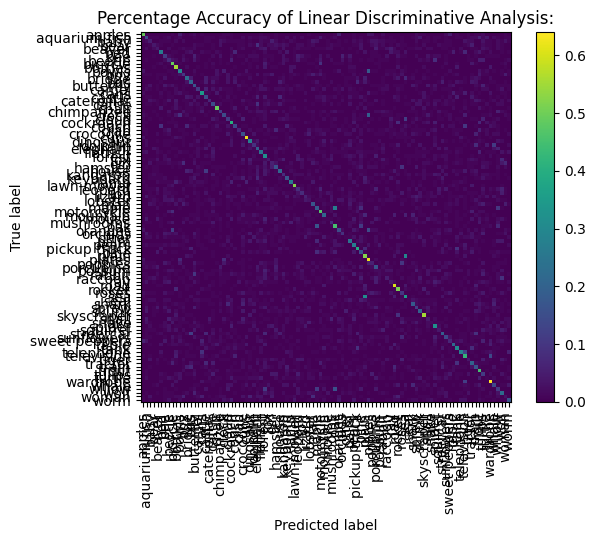

Classification Report of Linear Discriminative Analysis:
               precision    recall  f1-score   support

       apples       0.52      0.49      0.50       100
aquarium fish       0.16      0.15      0.15       100
         baby       0.09      0.05      0.06       100
         bear       0.09      0.04      0.06       100
       beaver       0.05      0.04      0.05       100
          bed       0.33      0.26      0.29       100
          bee       0.11      0.11      0.11       100
       beetle       0.08      0.08      0.08       100
      bicycle       0.33      0.49      0.39       100
      bottles       0.35      0.55      0.43       100
        bowls       0.27      0.29      0.28       100
          boy       0.11      0.10      0.10       100
       bridge       0.24      0.22      0.23       100
          bus       0.20      0.20      0.20       100
    butterfly       0.12      0.17      0.14       100
        camel       0.14      0.11      0.12       100
       

In [24]:
lda_and_report(2, train_features_fine, trnLabel_fine, test_features_fine, tstLabel_fine, fine_labels)

#### n_components=49

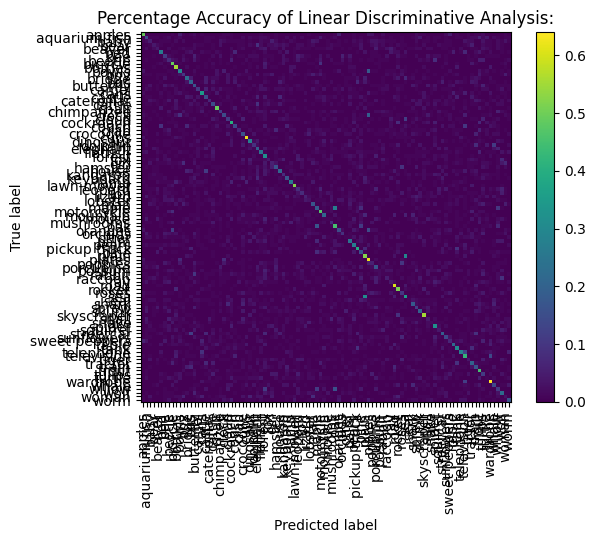

Classification Report of Linear Discriminative Analysis:
               precision    recall  f1-score   support

       apples       0.52      0.49      0.50       100
aquarium fish       0.16      0.15      0.15       100
         baby       0.09      0.05      0.06       100
         bear       0.09      0.04      0.06       100
       beaver       0.05      0.04      0.05       100
          bed       0.33      0.26      0.29       100
          bee       0.11      0.11      0.11       100
       beetle       0.08      0.08      0.08       100
      bicycle       0.33      0.49      0.39       100
      bottles       0.35      0.55      0.43       100
        bowls       0.27      0.29      0.28       100
          boy       0.11      0.10      0.10       100
       bridge       0.24      0.22      0.23       100
          bus       0.20      0.20      0.20       100
    butterfly       0.12      0.17      0.14       100
        camel       0.14      0.11      0.12       100
       

In [25]:
lda_and_report(49, train_features_fine, trnLabel_fine, test_features_fine, tstLabel_fine, fine_labels)

#### n_components=99

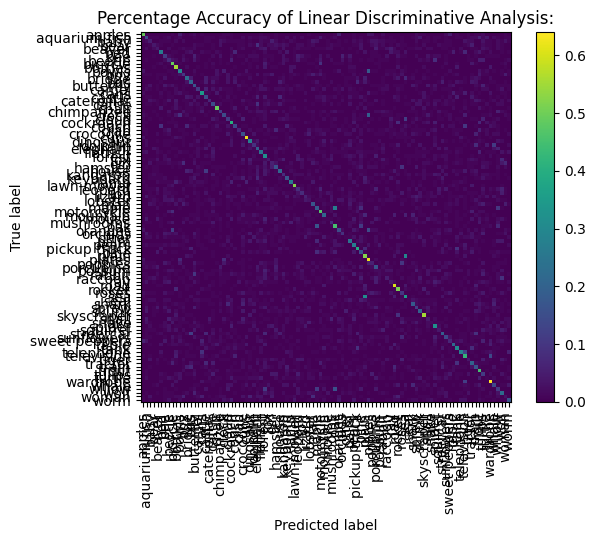

Classification Report of Linear Discriminative Analysis:
               precision    recall  f1-score   support

       apples       0.52      0.49      0.50       100
aquarium fish       0.16      0.15      0.15       100
         baby       0.09      0.05      0.06       100
         bear       0.09      0.04      0.06       100
       beaver       0.05      0.04      0.05       100
          bed       0.33      0.26      0.29       100
          bee       0.11      0.11      0.11       100
       beetle       0.08      0.08      0.08       100
      bicycle       0.33      0.49      0.39       100
      bottles       0.35      0.55      0.43       100
        bowls       0.27      0.29      0.28       100
          boy       0.11      0.10      0.10       100
       bridge       0.24      0.22      0.23       100
          bus       0.20      0.20      0.20       100
    butterfly       0.12      0.17      0.14       100
        camel       0.14      0.11      0.12       100
       

In [26]:
lda_and_report(99, train_features_fine, trnLabel_fine, test_features_fine, tstLabel_fine, fine_labels)

<hr>

## Algorithm 3 - Support Vector Machine

In [27]:
# Create and train a multiclass SVM on training data using SVC()
def svc_and_report(c_value, trn_std, trn_labels, tst_std, tst_labels, labels, label_type):
    svc = SVC(C=c_value)
    svc.fit(trn_std, trn_labels)

    # Predicting labels for testing set using SVC().predict()
    ss_test_predict = svc.predict(tst_std)
    ss_test_accuracy = svc.score(tst_std, tst_labels)
    print("Testing prediction accuracy (SVM) =", ss_test_accuracy)

    calculate_confusion_matrix("Support Vector Machine (" + label_type + ")", ss_test_predict, tst_labels, labels)
    calculate_classification_report("Support Vector Machine (" + label_type + ")", ss_test_predict, tst_labels, labels)

### Coarse Labels

#### C=1.0 (default)

Testing prediction accuracy (SVM) = 0.4016


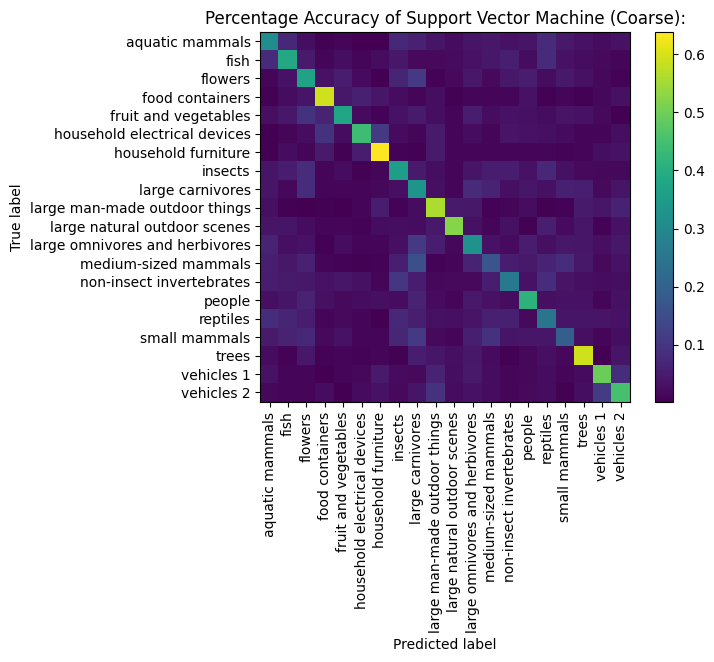

Classification Report of Support Vector Machine (Coarse):
                                precision    recall  f1-score   support

               aquatic mammals       0.32      0.31      0.31       500
                          fish       0.37      0.39      0.38       500
                       flowers       0.31      0.37      0.34       500
               food containers       0.58      0.59      0.58       500
          fruit and vegetables       0.49      0.38      0.43       500
  household electrical devices       0.56      0.44      0.49       500
           household furniture       0.59      0.64      0.61       500
                       insects       0.33      0.36      0.34       500
              large carnivores       0.25      0.33      0.28       500
 large man-made outdoor things       0.46      0.56      0.51       500
  large natural outdoor scenes       0.59      0.52      0.56       500
large omnivores and herbivores       0.30      0.33      0.31       500
     

In [28]:
svc_and_report(1.0, ss_train_coarse_std, trnLabel_coarse, ss_test_coarse_std, tstLabel_coarse, coarse_labels, "Coarse")

#### C=5.0

Testing prediction accuracy (SVM) = 0.4168


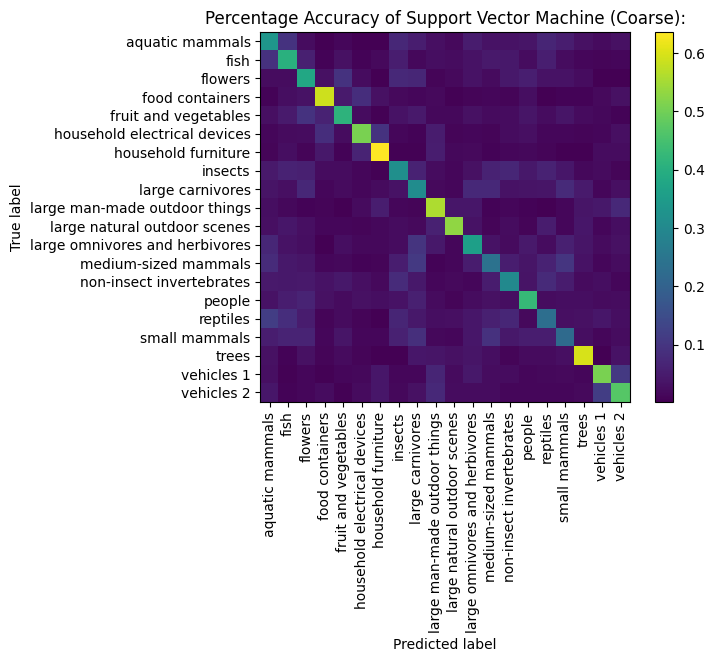

Classification Report of Support Vector Machine (Coarse):
                                precision    recall  f1-score   support

               aquatic mammals       0.29      0.33      0.31       500
                          fish       0.36      0.40      0.38       500
                       flowers       0.34      0.38      0.36       500
               food containers       0.58      0.59      0.58       500
          fruit and vegetables       0.46      0.41      0.44       500
  household electrical devices       0.55      0.51      0.53       500
           household furniture       0.60      0.64      0.62       500
                       insects       0.31      0.32      0.32       500
              large carnivores       0.27      0.31      0.29       500
 large man-made outdoor things       0.48      0.56      0.52       500
  large natural outdoor scenes       0.61      0.53      0.57       500
large omnivores and herbivores       0.36      0.36      0.36       500
     

In [29]:
svc_and_report(5.0, ss_train_coarse_std, trnLabel_coarse, ss_test_coarse_std, tstLabel_coarse, coarse_labels, "Coarse")

#### C=10.0

Testing prediction accuracy (SVM) = 0.4149


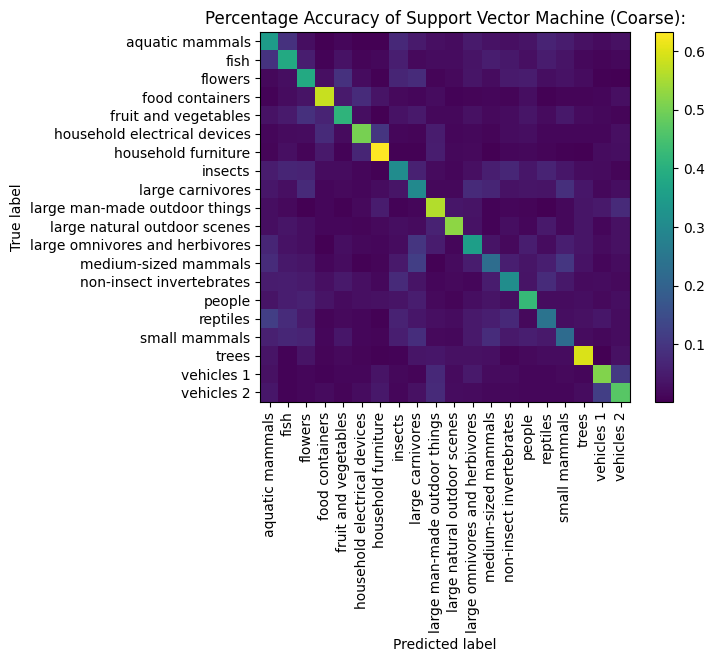

Classification Report of Support Vector Machine (Coarse):
                                precision    recall  f1-score   support

               aquatic mammals       0.30      0.35      0.32       500
                          fish       0.34      0.38      0.36       500
                       flowers       0.34      0.38      0.36       500
               food containers       0.57      0.58      0.58       500
          fruit and vegetables       0.46      0.41      0.43       500
  household electrical devices       0.55      0.50      0.53       500
           household furniture       0.60      0.63      0.61       500
                       insects       0.31      0.31      0.31       500
              large carnivores       0.27      0.30      0.28       500
 large man-made outdoor things       0.47      0.56      0.51       500
  large natural outdoor scenes       0.60      0.53      0.56       500
large omnivores and herbivores       0.36      0.36      0.36       500
     

In [30]:
svc_and_report(10.0, ss_train_coarse_std, trnLabel_coarse, ss_test_coarse_std, tstLabel_coarse, coarse_labels, "Coarse")

### Fine Labels

#### C=1.0

Testing prediction accuracy (SVM) = 0.2925


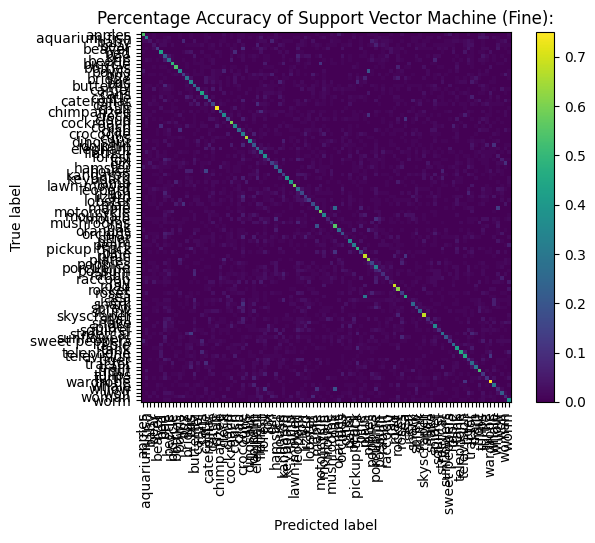

Classification Report of Support Vector Machine (Fine):
               precision    recall  f1-score   support

       apples       0.61      0.54      0.57       100
aquarium fish       0.35      0.33      0.34       100
         baby       0.12      0.04      0.06       100
         bear       0.06      0.04      0.05       100
       beaver       0.21      0.13      0.16       100
          bed       0.39      0.43      0.41       100
          bee       0.12      0.22      0.16       100
       beetle       0.22      0.27      0.24       100
      bicycle       0.43      0.49      0.46       100
      bottles       0.57      0.54      0.55       100
        bowls       0.31      0.34      0.33       100
          boy       0.24      0.14      0.18       100
       bridge       0.28      0.28      0.28       100
          bus       0.30      0.34      0.32       100
    butterfly       0.19      0.26      0.22       100
        camel       0.32      0.23      0.27       100
        

In [31]:
svc_and_report(1.0, ss_train_fine_std, trnLabel_fine, ss_test_fine_std, tstLabel_fine, fine_labels, "Fine")

#### C=5.0

Testing prediction accuracy (SVM) = 0.308


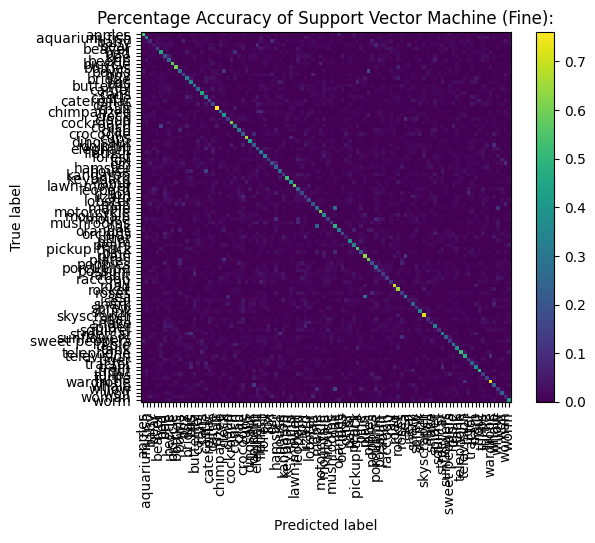

Classification Report of Support Vector Machine (Fine):
               precision    recall  f1-score   support

       apples       0.62      0.56      0.59       100
aquarium fish       0.31      0.35      0.33       100
         baby       0.16      0.10      0.12       100
         bear       0.06      0.04      0.05       100
       beaver       0.19      0.17      0.18       100
          bed       0.40      0.47      0.43       100
          bee       0.14      0.19      0.16       100
       beetle       0.20      0.25      0.22       100
      bicycle       0.46      0.57      0.51       100
      bottles       0.54      0.60      0.57       100
        bowls       0.23      0.28      0.25       100
          boy       0.26      0.18      0.21       100
       bridge       0.28      0.33      0.31       100
          bus       0.32      0.36      0.34       100
    butterfly       0.24      0.29      0.26       100
        camel       0.26      0.25      0.25       100
        

In [32]:
svc_and_report(5.0, ss_train_fine_std, trnLabel_fine, ss_test_fine_std, tstLabel_fine, fine_labels, "Fine")

#### C=10.0

Testing prediction accuracy (SVM) = 0.3062


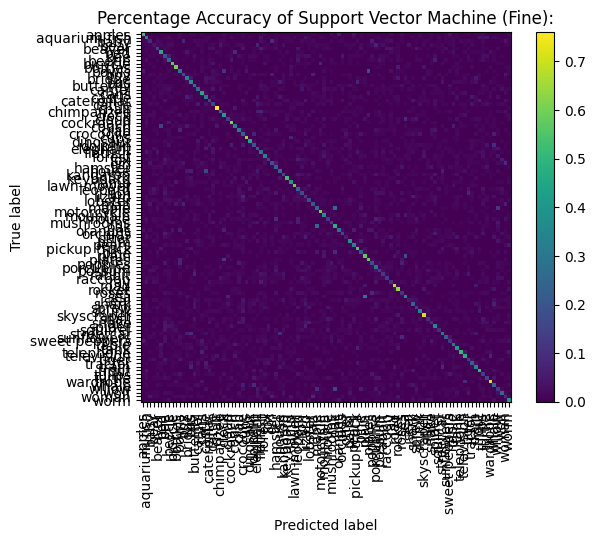

Classification Report of Support Vector Machine (Fine):
               precision    recall  f1-score   support

       apples       0.61      0.55      0.58       100
aquarium fish       0.30      0.34      0.32       100
         baby       0.16      0.10      0.12       100
         bear       0.06      0.04      0.05       100
       beaver       0.18      0.16      0.17       100
          bed       0.39      0.46      0.42       100
          bee       0.14      0.19      0.16       100
       beetle       0.21      0.26      0.23       100
      bicycle       0.46      0.57      0.51       100
      bottles       0.54      0.60      0.57       100
        bowls       0.24      0.29      0.26       100
          boy       0.26      0.18      0.21       100
       bridge       0.28      0.33      0.31       100
          bus       0.33      0.37      0.35       100
    butterfly       0.25      0.29      0.27       100
        camel       0.26      0.25      0.25       100
        

In [33]:
svc_and_report(10.0, ss_train_fine_std, trnLabel_fine, ss_test_fine_std, tstLabel_fine, fine_labels, "Fine")

<hr>

## Algorithm 4 - Neural Networks

### Coarse Labels

In [34]:
# Building Tensorflow model
num_coarse_labels = len(np.unique(coarse_labels))
model_coarse = tf.keras.Sequential(layers=[
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_coarse_labels, activation=tf.nn.softmax)])

# Compiling model
model_coarse.compile(optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy())

# Training model
history_coarse = model_coarse.fit(ss_train_coarse_std, trnLabel_coarse, epochs=100, verbose=2, validation_data=(test_features, tstLabel_coarse))
model_coarse.summary()

Epoch 1/100
1563/1563 - 6s - loss: 2.5070 - sparse_categorical_accuracy: 0.2343 - val_loss: 2.9580 - val_sparse_categorical_accuracy: 0.0789 - 6s/epoch - 4ms/step
Epoch 2/100
1563/1563 - 4s - loss: 2.1737 - sparse_categorical_accuracy: 0.3299 - val_loss: 2.9597 - val_sparse_categorical_accuracy: 0.0681 - 4s/epoch - 2ms/step
Epoch 3/100
1563/1563 - 3s - loss: 2.0202 - sparse_categorical_accuracy: 0.3781 - val_loss: 2.9329 - val_sparse_categorical_accuracy: 0.0963 - 3s/epoch - 2ms/step
Epoch 4/100
1563/1563 - 3s - loss: 1.8961 - sparse_categorical_accuracy: 0.4141 - val_loss: 2.9182 - val_sparse_categorical_accuracy: 0.0963 - 3s/epoch - 2ms/step
Epoch 5/100
1563/1563 - 4s - loss: 1.7833 - sparse_categorical_accuracy: 0.4488 - val_loss: 2.9209 - val_sparse_categorical_accuracy: 0.0908 - 4s/epoch - 2ms/step
Epoch 6/100
1563/1563 - 4s - loss: 1.6711 - sparse_categorical_accuracy: 0.4844 - val_loss: 2.9161 - val_sparse_categorical_accuracy: 0.1079 - 4s/epoch - 2ms/step
Epoch 7/100
1563/1563 

313/313 [==============================] - 0s 947us/step


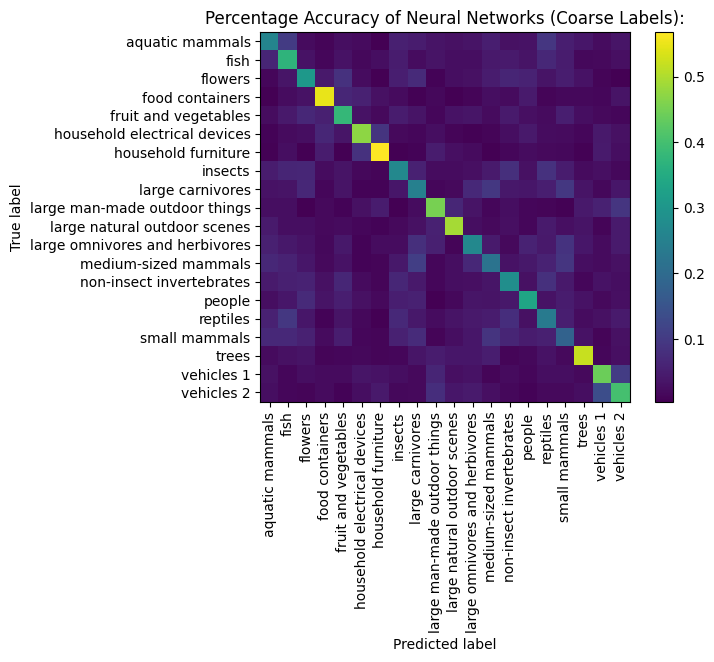

Classification Report of Neural Networks (Coarse Labels):
                                precision    recall  f1-score   support

               aquatic mammals       0.28      0.26      0.27       500
                          fish       0.32      0.37      0.34       500
                       flowers       0.30      0.30      0.30       500
               food containers       0.53      0.55      0.54       500
          fruit and vegetables       0.36      0.38      0.37       500
  household electrical devices       0.50      0.47      0.48       500
           household furniture       0.57      0.57      0.57       500
                       insects       0.29      0.27      0.28       500
              large carnivores       0.24      0.25      0.25       500
 large man-made outdoor things       0.44      0.45      0.44       500
  large natural outdoor scenes       0.49      0.49      0.49       500
large omnivores and herbivores       0.29      0.27      0.28       500
     

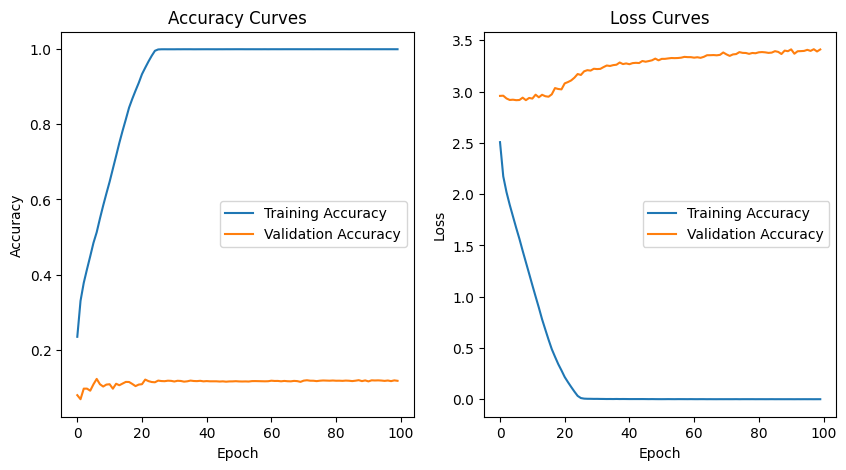

In [35]:
nn_test_predict_coarse = model_coarse.predict(ss_test_coarse_std)
nn_test_predict_coarse_labels = np.argmax(nn_test_predict_coarse, axis=1)
calculate_confusion_matrix("Neural Networks (Coarse Labels)", nn_test_predict_coarse_labels, tstLabel_coarse, coarse_labels) #name, predicted_data, test_label, label_names

calculate_classification_report("Neural Networks (Coarse Labels)", nn_test_predict_coarse_labels, tstLabel_coarse, coarse_labels)
plot_acc_loss_curves(history_coarse)

### Fine Labels

In [36]:
# Building Tensorflow model
num_fine_labels = len(np.unique(fine_labels))
model_fine = tf.keras.Sequential(layers=[
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_fine_labels, activation=tf.nn.softmax)])

# Compiling model
model_fine.compile(optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy())

# Training model
history_fine = model_fine.fit(ss_train_fine_std, trnLabel_fine, epochs=100, verbose=2, validation_data=(test_features_fine, tstLabel_fine))
model_fine.summary()

Epoch 1/100
1563/1563 - 4s - loss: 4.2466 - sparse_categorical_accuracy: 0.0736 - val_loss: 4.5490 - val_sparse_categorical_accuracy: 0.0245 - 4s/epoch - 3ms/step
Epoch 2/100
1563/1563 - 4s - loss: 3.5541 - sparse_categorical_accuracy: 0.1725 - val_loss: 4.5581 - val_sparse_categorical_accuracy: 0.0240 - 4s/epoch - 2ms/step
Epoch 3/100
1563/1563 - 4s - loss: 3.2819 - sparse_categorical_accuracy: 0.2221 - val_loss: 4.5462 - val_sparse_categorical_accuracy: 0.0330 - 4s/epoch - 2ms/step
Epoch 4/100
1563/1563 - 3s - loss: 3.1043 - sparse_categorical_accuracy: 0.2556 - val_loss: 4.5355 - val_sparse_categorical_accuracy: 0.0263 - 3s/epoch - 2ms/step
Epoch 5/100
1563/1563 - 3s - loss: 2.9591 - sparse_categorical_accuracy: 0.2835 - val_loss: 4.5484 - val_sparse_categorical_accuracy: 0.0268 - 3s/epoch - 2ms/step
Epoch 6/100
1563/1563 - 3s - loss: 2.8253 - sparse_categorical_accuracy: 0.3092 - val_loss: 4.5540 - val_sparse_categorical_accuracy: 0.0247 - 3s/epoch - 2ms/step
Epoch 7/100
1563/1563 

313/313 [==============================] - 0s 950us/step


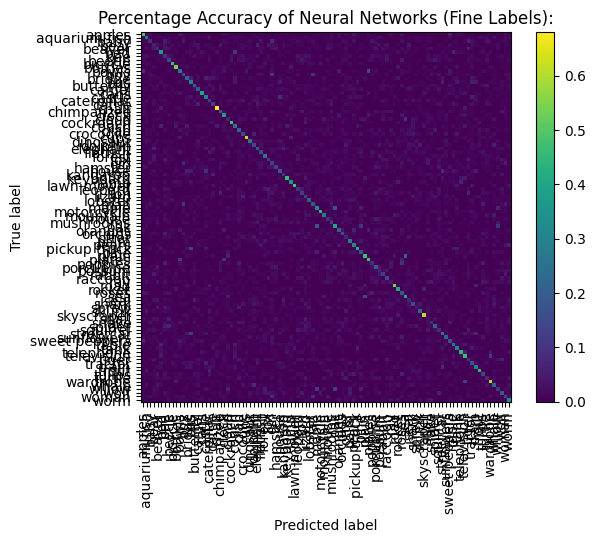

Classification Report of Neural Networks (Fine Labels):
               precision    recall  f1-score   support

       apples       0.45      0.50      0.47       100
aquarium fish       0.29      0.28      0.29       100
         baby       0.13      0.08      0.10       100
         bear       0.07      0.06      0.06       100
       beaver       0.08      0.08      0.08       100
          bed       0.38      0.37      0.37       100
          bee       0.08      0.10      0.09       100
       beetle       0.16      0.14      0.15       100
      bicycle       0.49      0.46      0.48       100
      bottles       0.47      0.54      0.50       100
        bowls       0.25      0.27      0.26       100
          boy       0.16      0.16      0.16       100
       bridge       0.23      0.23      0.23       100
          bus       0.28      0.30      0.29       100
    butterfly       0.21      0.21      0.21       100
        camel       0.21      0.19      0.20       100
        

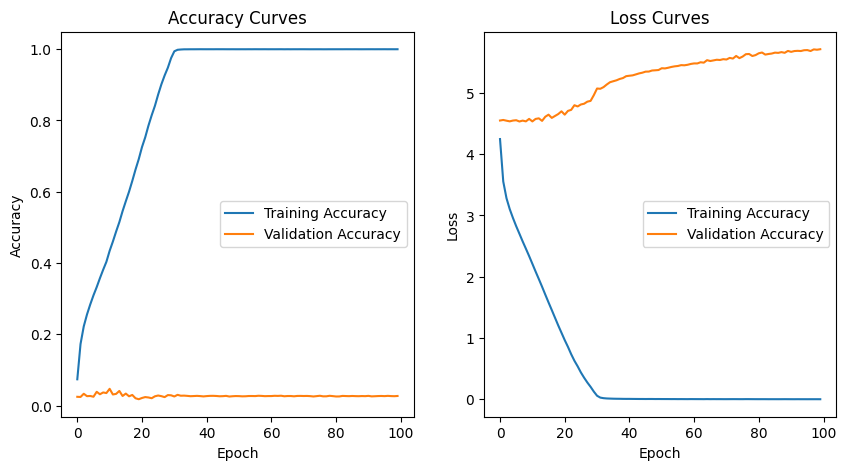

In [37]:
nn_test_predict_fine = model_fine.predict(ss_test_fine_std)
nn_test_predict_fine_labels = np.argmax(nn_test_predict_fine, axis=1)
calculate_confusion_matrix("Neural Networks (Fine Labels)", nn_test_predict_fine_labels, tstLabel_fine, fine_labels)

calculate_classification_report("Neural Networks (Fine Labels)", nn_test_predict_fine_labels, tstLabel_fine, fine_labels)
plot_acc_loss_curves(history_fine)

<hr>

## Algorithm 5 - Convolutional Neural Networks

### Coarse Labels

In [38]:
# Get number of unique labels and convert labels to matrix (so it can be used with model)
cnn_model_coarse = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(np.unique(coarse_labels)), activation=tf.nn.softmax)])


cnn_model_coarse.compile(optimizer=tf.keras.optimizers.SGD(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=tf.keras.metrics.SparseCategoricalAccuracy())


cnn_history_coarse = cnn_model_coarse.fit(trnImage, trnLabel_coarse, epochs=100, verbose=2, validation_data=(tstImage, tstLabel_coarse))
cnn_model_coarse.summary()

Epoch 1/100
1563/1563 - 10s - loss: 2.7403 - sparse_categorical_accuracy: 0.1493 - val_loss: 2.5855 - val_sparse_categorical_accuracy: 0.2183 - 10s/epoch - 6ms/step
Epoch 2/100
1563/1563 - 5s - loss: 2.4676 - sparse_categorical_accuracy: 0.2357 - val_loss: 2.4390 - val_sparse_categorical_accuracy: 0.2670 - 5s/epoch - 3ms/step
Epoch 3/100
1563/1563 - 5s - loss: 2.2995 - sparse_categorical_accuracy: 0.2869 - val_loss: 2.3255 - val_sparse_categorical_accuracy: 0.2745 - 5s/epoch - 3ms/step
Epoch 4/100
1563/1563 - 5s - loss: 2.1748 - sparse_categorical_accuracy: 0.3243 - val_loss: 2.2320 - val_sparse_categorical_accuracy: 0.3066 - 5s/epoch - 3ms/step
Epoch 5/100
1563/1563 - 5s - loss: 2.0830 - sparse_categorical_accuracy: 0.3521 - val_loss: 2.1040 - val_sparse_categorical_accuracy: 0.3629 - 5s/epoch - 3ms/step
Epoch 6/100
1563/1563 - 5s - loss: 2.0021 - sparse_categorical_accuracy: 0.3790 - val_loss: 2.0913 - val_sparse_categorical_accuracy: 0.3617 - 5s/epoch - 3ms/step
Epoch 7/100
1563/156

313/313 [==============================] - 1s 2ms/step


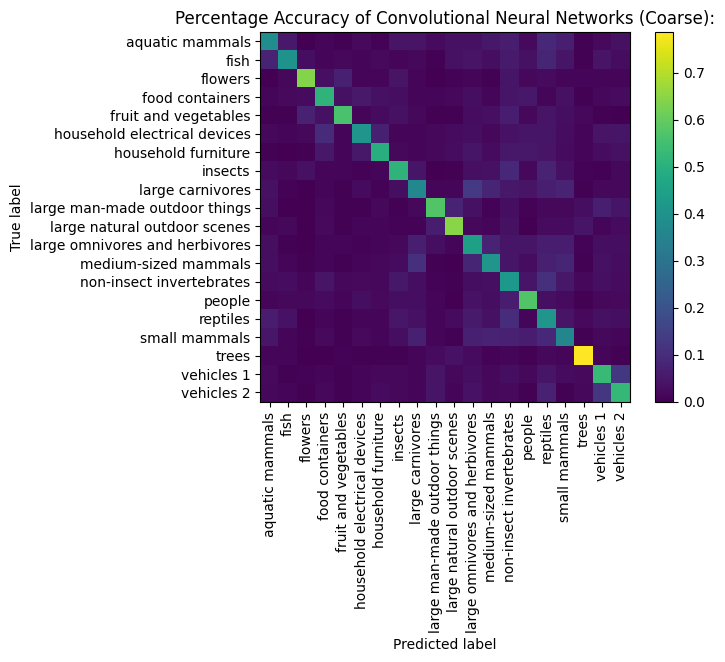

Classification Report of Convolutional Neural Networks (Coarse):
                                precision    recall  f1-score   support

               aquatic mammals       0.45      0.38      0.41       500
                          fish       0.58      0.40      0.47       500
                       flowers       0.73      0.64      0.68       500
               food containers       0.53      0.51      0.52       500
          fruit and vegetables       0.69      0.56      0.62       500
  household electrical devices       0.54      0.41      0.47       500
           household furniture       0.59      0.50      0.54       500
                       insects       0.52      0.51      0.52       500
              large carnivores       0.39      0.37      0.38       500
 large man-made outdoor things       0.63      0.57      0.60       500
  large natural outdoor scenes       0.64      0.65      0.65       500
large omnivores and herbivores       0.36      0.45      0.40       50

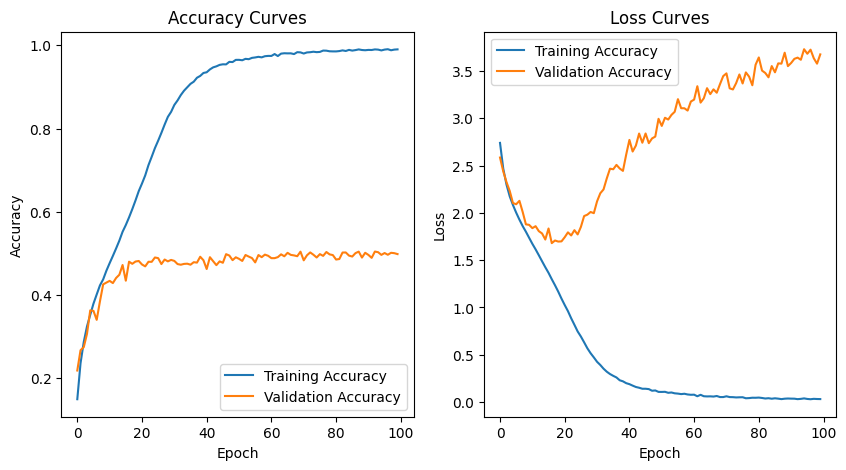

In [39]:
cnn_test_predict_coarse = cnn_model_coarse.predict(tstImage)
cnn_test_predict_coarse_labels = np.argmax(cnn_test_predict_coarse, axis=1)
calculate_confusion_matrix("Convolutional Neural Networks (Coarse)", cnn_test_predict_coarse_labels, tstLabel_coarse, coarse_labels)
calculate_classification_report("Convolutional Neural Networks (Coarse)", cnn_test_predict_coarse_labels, tstLabel_coarse, coarse_labels)
plot_acc_loss_curves(cnn_history_coarse)

### Fine Labels

In [40]:
# Get number of unique labels and convert labels to matrix (so it can be used with model)
cnn_model_fine = tf.keras.Sequential(layers=[
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation=tf.nn.relu),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(256, activation=tf.nn.relu),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(np.unique(fine_labels)), activation=tf.nn.softmax)])


cnn_model_fine.compile(optimizer=tf.keras.optimizers.SGD(),
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  metrics=tf.keras.metrics.SparseCategoricalAccuracy())


cnn_history_fine = cnn_model_fine.fit(trnImage, trnLabel_fine, epochs=100, verbose=2, validation_data=(tstImage, tstLabel_fine))
cnn_model_fine.summary()

Epoch 1/100
1563/1563 - 6s - loss: 4.5089 - sparse_categorical_accuracy: 0.0282 - val_loss: 4.3118 - val_sparse_categorical_accuracy: 0.0445 - 6s/epoch - 4ms/step
Epoch 2/100
1563/1563 - 5s - loss: 4.0769 - sparse_categorical_accuracy: 0.0744 - val_loss: 4.0060 - val_sparse_categorical_accuracy: 0.0933 - 5s/epoch - 3ms/step
Epoch 3/100
1563/1563 - 5s - loss: 3.8428 - sparse_categorical_accuracy: 0.1114 - val_loss: 3.9144 - val_sparse_categorical_accuracy: 0.1025 - 5s/epoch - 3ms/step
Epoch 4/100
1563/1563 - 5s - loss: 3.6932 - sparse_categorical_accuracy: 0.1375 - val_loss: 3.7476 - val_sparse_categorical_accuracy: 0.1424 - 5s/epoch - 3ms/step
Epoch 5/100
1563/1563 - 5s - loss: 3.5600 - sparse_categorical_accuracy: 0.1597 - val_loss: 3.6331 - val_sparse_categorical_accuracy: 0.1553 - 5s/epoch - 3ms/step
Epoch 6/100
1563/1563 - 5s - loss: 3.4279 - sparse_categorical_accuracy: 0.1807 - val_loss: 3.4644 - val_sparse_categorical_accuracy: 0.1872 - 5s/epoch - 3ms/step
Epoch 7/100
1563/1563 

313/313 [==============================] - 0s 1ms/step


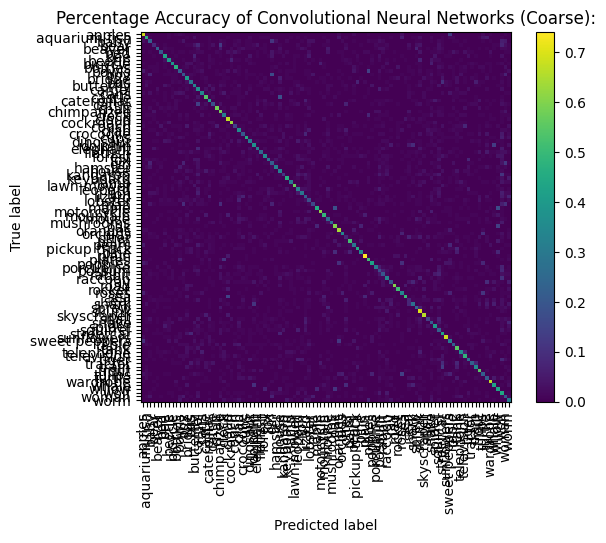

Classification Report of Convolutional Neural Networks (Coarse):
               precision    recall  f1-score   support

       apples       0.55      0.69      0.61       100
aquarium fish       0.53      0.47      0.50       100
         baby       0.26      0.23      0.25       100
         bear       0.21      0.09      0.13       100
       beaver       0.35      0.23      0.28       100
          bed       0.48      0.21      0.29       100
          bee       0.42      0.43      0.42       100
       beetle       0.47      0.41      0.44       100
      bicycle       0.45      0.39      0.42       100
      bottles       0.53      0.47      0.50       100
        bowls       0.21      0.23      0.22       100
          boy       0.24      0.20      0.22       100
       bridge       0.29      0.40      0.33       100
          bus       0.37      0.29      0.33       100
    butterfly       0.29      0.33      0.31       100
        camel       0.20      0.37      0.26       100

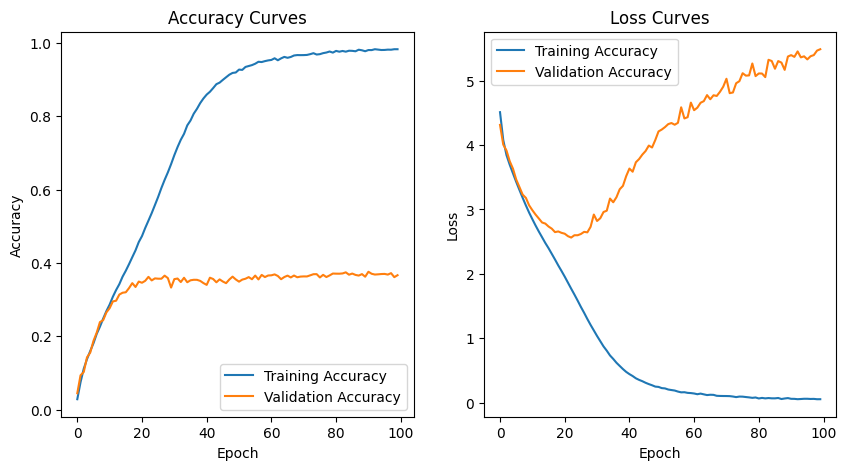

In [41]:
cnn_test_predict_fine = cnn_model_fine.predict(tstImage)
cnn_test_predict_fine_labels = np.argmax(cnn_test_predict_fine, axis=1)
calculate_confusion_matrix("Convolutional Neural Networks (Coarse)", cnn_test_predict_fine_labels, tstLabel_fine, fine_labels)
calculate_classification_report("Convolutional Neural Networks (Coarse)", cnn_test_predict_fine_labels, tstLabel_fine, fine_labels)
plot_acc_loss_curves(cnn_history_fine)